### Load Model

In [23]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [13]:
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = 'tomato/train'
VAL_DIRECTORY = 'tomato/valid'
TEST_DIRECTORY = 'tomato/test'

In [ ]:
import os
import torchvision
import supervision as sv

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_dir: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_dir, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_dir, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [ ]:
import os
import random
import numpy as np
import cv2
import torchvision
from albumentations import (
    Compose, Mosaic, HorizontalFlip, VerticalFlip,
    ShiftScaleRotate, Affine, ChannelShuffle,
    HueSaturationValue, RandomBrightnessContrast,
    CoarseDropout
)
from albumentations.pytorch import ToTensorV2

def yolo_transforms(
    img_size: int = 640,
    hsv_h: float = 0.015,
    hsv_s: float = 0.7,
    hsv_v: float = 0.4,
    degrees: float = 0.0,
    translate: float = 0.1,
    scale: float = 0.5,
    shear: float = 0.0,
    flipud: float = 0.0,
    fliplr: float = 0.5,
    bgr: float = 0.0,
    mosaic: float = 1.0,
    erasing: float = 0.4
):
    hue_deg = int(hsv_h * 180)
    sat_val = int(hsv_s * 255)
    val_val = int(hsv_v * 255)

    transforms = []

    transforms.append(Mosaic(p=mosaic, min_scale=0.5, pad_val=114))

    transforms.append(HorizontalFlip(p=fliplr))
    transforms.append(VerticalFlip(p=flipud))

    transforms.append(ShiftScaleRotate(
        shift_limit=translate,
        scale_limit=scale,
        rotate_limit=degrees,
        border_mode=cv2.BORDER_CONSTANT,
        pad_val=114,
        p=1.0
    ))

    transforms.append(Affine(shear=shear, fit_output=False, pad_val=114, p=1.0))

    transforms.append(ChannelShuffle(p=bgr))

    transforms.append(HueSaturationValue(
        hue_shift_limit=hue_deg,
        sat_shift_limit=sat_val,
        val_shift_limit=val_val,
        p=1.0
    ))
    transforms.append(RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=1.0
    ))

    transforms.append(CoarseDropout(
        max_holes=1,
        max_height=int(img_size * erasing),
        max_width=int(img_size * erasing),
        min_holes=1,
        fill_value=114,
        p=erasing
    ))

    transforms.append(ToTensorV2())

    return Compose(
        transforms,
        bbox_params={'format': 'coco', 'label_fields': ['category_id']}
    )


class CocoDetectionAugmentated(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_dir: str,
        image_processor,
        augmentations=None
    ):
        ann_file = os.path.join(image_dir, ANNOTATION_FILE_NAME)
        super().__init__(image_dir, ann_file)
        self.image_processor = image_processor
        self.augmentations = augmentations

    def __getitem__(self, idx):
        img, annots = super().__getitem__(idx)
        image_id = self.ids[idx]

        bboxes = [o['bbox'] for o in annots]
        labels = [o['category_id'] for o in annots]

        if self.augmentations and bboxes:
            img_np = np.array(img)[:, :, ::-1]  
            aug = self.augmentations(
                image=img_np,
                bboxes=bboxes,
                category_id=labels
            )
            img = aug['image']
            bboxes = aug['bboxes']
            labels = aug['category_id']

        ann_out = {
            'image_id': image_id,
            'annotations': [
                {
                    'bbox': bb,
                    'category_id': c,
                    'area': bb[2] * bb[3],
                    'iscrowd': 0
                }
                for bb, c in zip(bboxes, labels)
            ]
        }

        encoding = self.image_processor(
            images=img,
            annotations=ann_out,
            return_tensors='pt'
        )
        pixel_values = encoding['pixel_values'].squeeze(0)
        target = encoding['labels'][0]

        return pixel_values, target


In [16]:
TRAIN_DATASET = CocoDetection(
    image_dir=TRAIN_DIRECTORY,
    image_processor=image_processor)
VAL_DATASET = CocoDetection(
    image_dir=VAL_DIRECTORY,
    image_processor=image_processor)
TEST_DATASET = CocoDetection(
    image_dir=TEST_DIRECTORY,
    image_processor=image_processor)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 4692
Number of validation examples: 438
Number of test examples: 443


## Visualize data entry

Image #2480


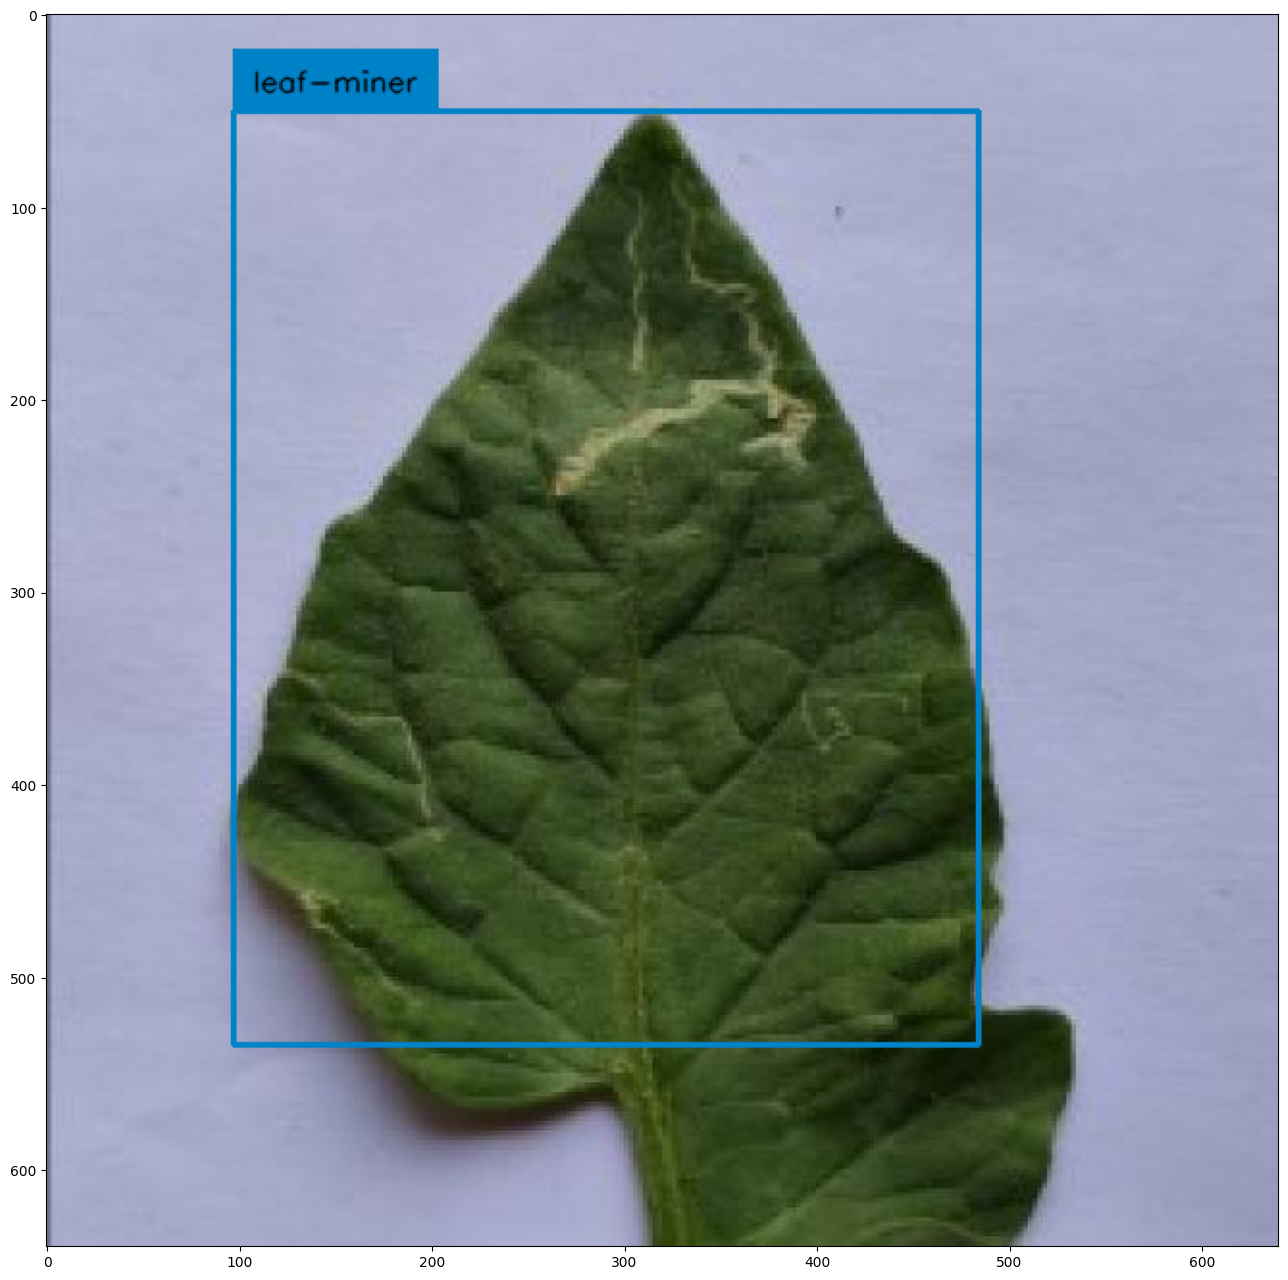

In [17]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

In [18]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=16, shuffle=True, num_workers=4)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=16, num_workers=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=16, num_workers=4)

## Train model with PyTorch Lightning

**NOTE:** Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

**NOTE:** Let's start `tensorboard`.

In [20]:
from torchmetrics.detection import MeanAveragePrecision
import torch
import pytorch_lightning as pl

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        # Метрика для mAP (включая mAP@50)
        self.map_metric = MeanAveragePrecision(box_format="xywh", iou_thresholds=[0.5, 0.75], class_metrics=True)
        self.validation_step_outputs = []  # Для накопления batch-предсказаний

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict, outputs, labels

    def training_step(self, batch, batch_idx):
        self.model.train()
        # print(f"Model is in {'train' if self.model.training else 'eval'} mode")
        loss, loss_dict, _, _ = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        self.model.eval()
        loss, loss_dict, outputs, labels = self.common_step(batch, batch_idx)
        
        # Получаем предсказанные боксы (в формате DETR)
        preds = self._convert_outputs_to_coco_format(outputs)
        targets = self._convert_labels_to_coco_format(labels)
        
        # Обновляем метрики
        self.map_metric.update(preds, targets)
        
        # Логируем loss
        self.log("val_loss", loss, prog_bar=True)
#         for k, v in loss_dict.items():
#             self.log(f"val_{k}", v.item())
        
        # Сохраняем для агрегации (если нужно)
        self.validation_step_outputs.append({"loss": loss, "preds": preds, "targets": targets})
        return loss

    def on_validation_epoch_end(self):
        # Вычисляем метрики (mAP, Precision, Recall)
        map_results = self.map_metric.compute()
        
        # Логируем метрики
        self.log("val_mAP50", map_results["map_50"], prog_bar=True)
        self.log("val_mAP", map_results["map"], prog_bar=False)
        # self.log("val_precision", map_results["precision"].mean(), prog_bar=True)
        self.log("val_recall", map_results["mar_100"], prog_bar=True)  # MAR = mean Average Recall
        
        # Очищаем метрики для следующей эпохи
        self.map_metric.reset()
        self.validation_step_outputs.clear()

    def _convert_outputs_to_coco_format(self, outputs):
        # Конвертируем выходы DETR в формат COCO (для torchmetrics)
        preds = []
        for i in range(len(outputs.logits)):
            boxes = outputs.pred_boxes[i].detach().cpu()
            scores = outputs.logits[i].softmax(-1)[:, :-1].max(-1).values.detach().cpu()
            labels = outputs.logits[i].softmax(-1)[:, :-1].argmax(-1).detach().cpu()
            
            preds.append({
                "boxes": boxes,
                "scores": scores,
                "labels": labels,
            })
        return preds

    def _convert_labels_to_coco_format(self, labels):
        # Конвертируем GT-боксы в формат COCO
        targets = []
        for label in labels:
            targets.append({
                "boxes": label["boxes"].cpu(),
                "labels": label["class_labels"].cpu(),
            })
        return targets

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [21]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# batch = next(iter(TRAIN_DATALOADER))
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

/home/kirill/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/kirill/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/kirill/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a met

In [22]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

# settings
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger(save_dir="logs", name="exp_csv")

checkpoint_callback = ModelCheckpoint(
    dirpath="my_checkpoints/",        # путь, куда сохранять чекпоинты
    filename="epoch{epoch:02d}",      # шаблон имени файла
    save_top_k=-1,                    # сохранять ВСЕ чекпоинты (а не только лучшие)
    every_n_epochs=1,                 # сохранять раз в каждую эпоху
    save_on_train_epoch_end=True,     # сохранять именно в конце train-части эпохи
)

MAX_EPOCHS = 100

trainer = Trainer(
    callbacks=[checkpoint_callback],
    accelerator="gpu",
    devices=1,
    max_epochs=MAX_EPOCHS,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
    logger=logger
    
)
# ckpt_path = "./my_checkpoints/epochepoch=48.ckpt"
# trainer.fit(model, ckpt_path=ckpt_path)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/kirill/miniconda3/envs/py310/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/kirill/my_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | DetrForObjectDetection | 41.5 M | eval 
1 | map_metric | MeanAveragePrecision   | 0      | train
----------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kirill/miniconda3/envs/py310/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/kirill/miniconda3/envs/py310/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import pandas as pd

# 1) Загрузить CSV
df = pd.read_csv("./logs/exp_csv/version_45/metrics.csv")

max_idx = df["val_mAP50"].idxmax()

max_row = df.loc[max_idx]

print("Row with highest ‘name’ value:")
print(max_row)


Row with highest ‘name’ value:
epoch                        26.000000
step                       7937.000000
train_cardinality_error            NaN
train_loss                         NaN
train_loss_bbox                    NaN
train_loss_ce                      NaN
train_loss_giou                    NaN
val_loss                      1.064947
val_mAP                       0.453529
val_mAP50                     0.516853
val_recall                    0.658256
Name: 7964, dtype: float64


## Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

In [ ]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

Image #288
ground truth


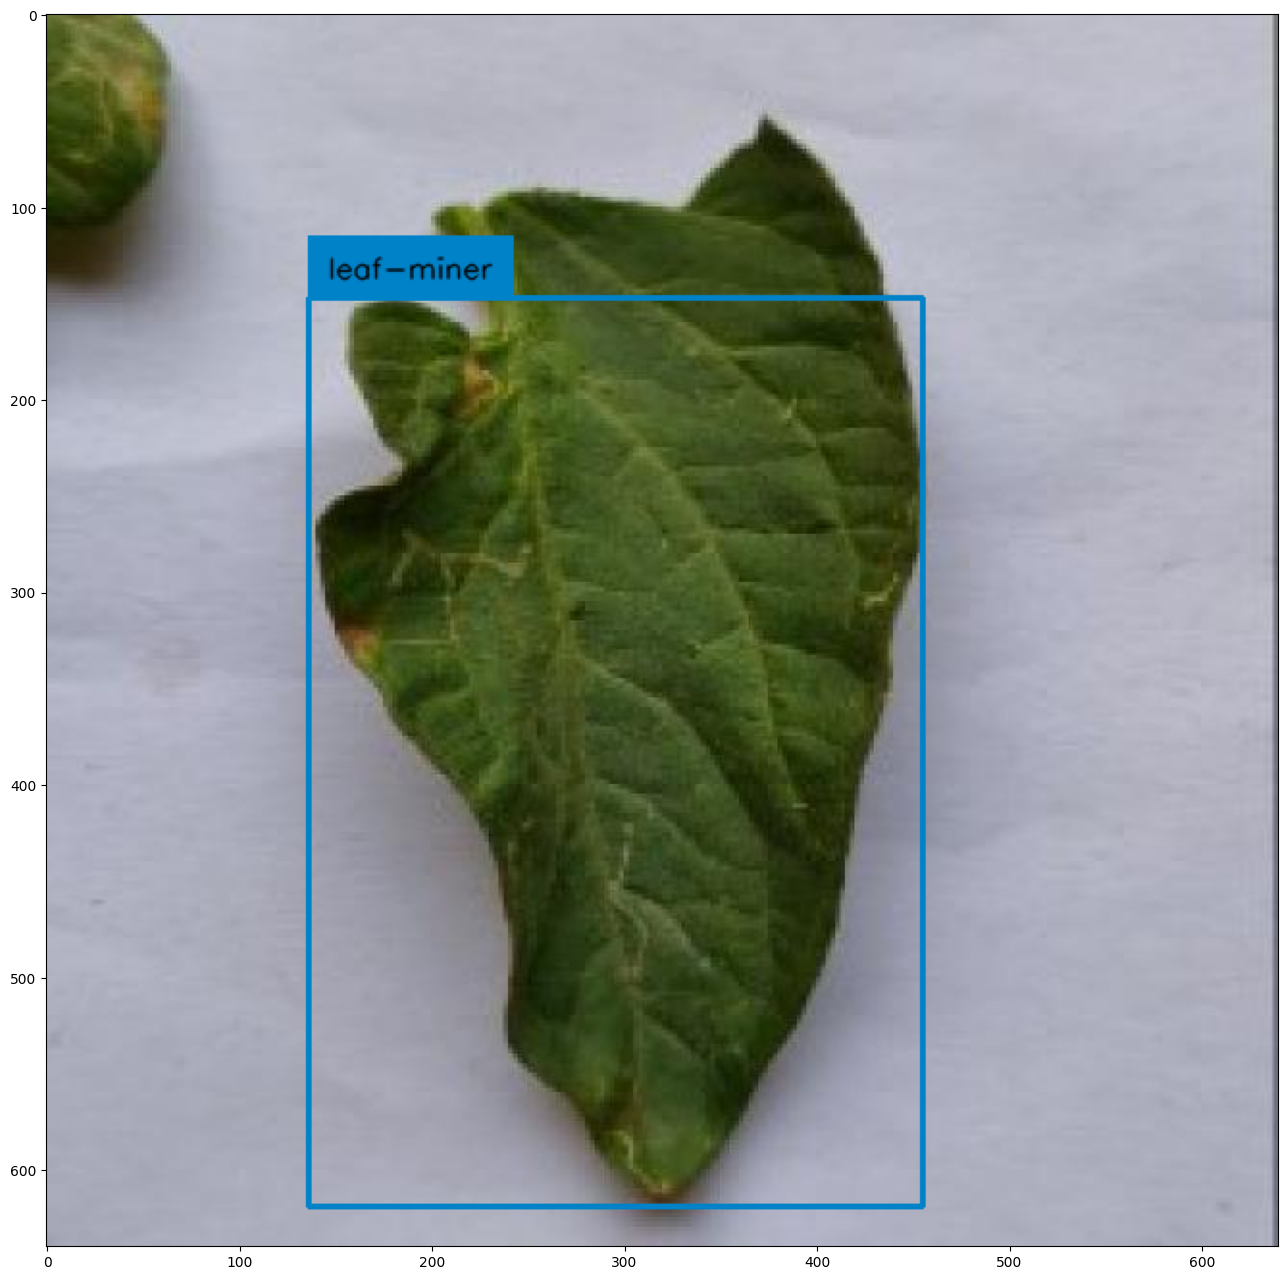

detections


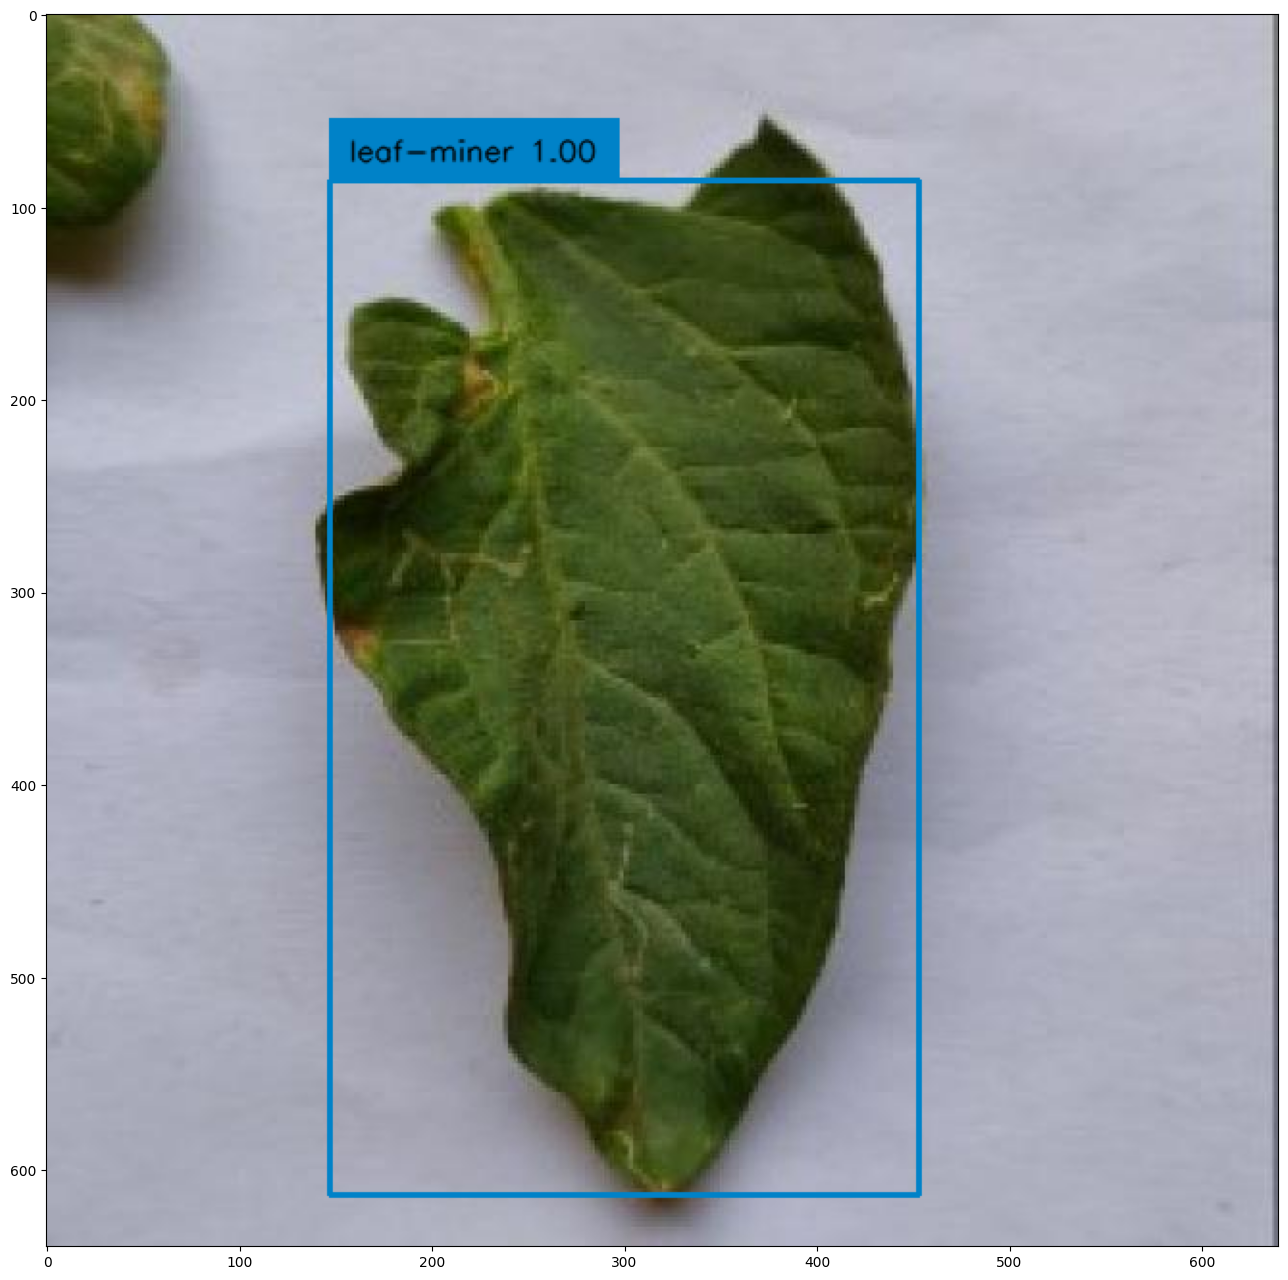

In [ ]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## Evaluation on test dataset

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/28 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

## Save and load model

In [ ]:
MODEL_PATH = os.path.join(".", 'custom-model')

In [ ]:
model.model.save_pretrained(MODEL_PATH)